## Description:
Extracts an HDF5 file of the entire field from the imported nek output file.

In [ ]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")

import yaml
from mpi4py import MPI

from flamekit.io_fronts import Case, folder
from flamekit.io_fields import make_case_with_base_dir, field_path
from flamekit.datasets import SEMDataset
import pandas as pd
import numpy as np


### Read config file and define helper functions

In [ ]:
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

PROJECT_ROOT = Path.cwd().resolve()

config_path = PROJECT_ROOT / "notebooks" / "preprocessing" / "extract_fields" / "extract_fields.yaml"
cfg = yaml.safe_load(config_path.read_text(encoding="utf-8"))

data_base_dir = PROJECT_ROOT / Path(cfg["DATA_BASE_DIR"])
output_base_dir = PROJECT_ROOT / Path(cfg["OUTPUT_BASE_DIR"])
post = bool(cfg["POST"])
file_name = "po_postPremix" if post else "premix"
hdf_format = str(cfg.get("HDF_FORMAT", "fixed"))

# time steps
time_step = int(cfg["TIME_STEP"])
multi_time_step = bool(cfg["MULTI_TIME_STEP"])
time_step_start = int(cfg["TIME_STEP_START"])
time_step_end = int(cfg["TIME_STEP_END"])

# case-identifier
phi = float(cfg["PHI"])
lat_size = str(cfg["LAT_SIZE"])

# scalars
scalars = list(cfg["SCALARS"])

# feature toggles
compute_vel_jacobian = bool(cfg["COMP_VEL_JACOBIAN"])
compute_vel_hessian = bool(cfg["COMP_VEL_HESSIAN"])
compute_T_grad = bool(cfg["COMP_T_GRAD"])
compute_curv_grad = bool(cfg["COMP_CURV_GRAD"])
compute_local_vel_jacobian = bool(cfg["COMP_LOCAL_VEL_JACOBIAN"])
compute_reaction_rates = bool(cfg.get("COMP_REACTION_RATES", False))

# Cantera inputs
T_REF = float(cfg["T_REF"])
P_REF = float(cfg["P_REF"])
CANTERA_YAML = PROJECT_ROOT / Path(cfg["CANTERA_YAML"])
CANTERA_INPUTS = [str(CANTERA_YAML), None, T_REF, P_REF]  # [cantera_file, species_list, t_ref, p_ref]


### Run

In [3]:
# Determine timesteps to process
if multi_time_step:
    ts_list = list(range(time_step_start, time_step_end + 1))
else:
    ts_list = [time_step]

# Build SEMDataset once (mesh + coef once)
init_ts = int(ts_list[0])
case0 = Case(base_dir=output_base_dir, phi=phi, lat_size=lat_size, time_step=init_ts, post=post)
data_case0 = make_case_with_base_dir(case0, data_base_dir)
data_folder0 = folder(data_case0)

ds = SEMDataset(
    folder_name=str(data_folder0),
    file_name=file_name,
    time_step=init_ts,
    comm=comm,
    scalar_names=scalars,
)

# Process timesteps
for ts in ts_list:
    ts = int(ts)
    if rank == 0:
        print(f"=== Processing TIME_STEP={ts} (MPI size={size}) ===")

    case = Case(base_dir=output_base_dir, phi=phi, lat_size=lat_size, time_step=ts, post=post)
    out_case = make_case_with_base_dir(case, output_base_dir)
    out_hdf_path = field_path(out_case)

    # Local read
    ds.reload_timestep(case.time_step)

    scalar_subset = None

    point_data = ds.build_point_data_dict(
        cantera_inputs=CANTERA_INPUTS,
        phi=phi,
        scalar_subset=scalar_subset,
        compute_progress_var=True,
        compute_vel_jacobian=compute_vel_jacobian,
        compute_vel_hessian=compute_vel_hessian,
        compute_T_grad=compute_T_grad,
        compute_curv_grad=compute_curv_grad,
        compute_local_vel_jacobian=compute_local_vel_jacobian,
        compute_reaction_rates=compute_reaction_rates,
    )
    # Convert to flat columns for pandas (rank-local)
    data = {
        "x": np.asarray(ds.x).ravel(order="C"),
        "y": np.asarray(ds.y).ravel(order="C"),
        "z": np.asarray(ds.z).ravel(order="C"),
    }

    n = data["x"].size

    for k, arr in point_data.items():
        v = np.asarray(arr).ravel(order="C")
        if v.size != n:
            raise ValueError(f"Column {k!r} has size {v.size}, expected {n}. Shape was {np.asarray(arr).shape}.")
        data[k] = v

    df = pd.DataFrame(data)

    # Output file per rank
    out_file = out_hdf_path if size == 1 else out_hdf_path.with_name(f"{out_hdf_path.stem}_rank{rank:04d}{out_hdf_path.suffix}")
    df.to_hdf(out_file, key="field", mode="w", format=hdf_format, index=False)

    if rank == 0:
        print(f"[rank0] Wrote: {out_file}")

comm.Barrier()

2026-01-24 21:39:06,322  pynekread             INFO      Reading file: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/nek/phi0.40/h400x025_ref/premix0.f00001
2026-01-24 21:39:06,356  Mesh                  INFO      Mesh object initialized from coordinates with type: float64 - Elapsed time: 0.024720625000000003s
2026-01-24 21:39:06,356  pynekread             INFO      File successfully read - Elapsed time: 0.034095556s
2026-01-24 21:39:06,357  Coef                  INFO      Initializing Coef object
2026-01-24 21:39:06,358  Coef                  INFO      Getting derivative matrices
2026-01-24 21:39:06,359  Coef                  INFO      Calculating the components of the jacobian
2026-01-24 21:39:06,392  Coef                  INFO      Calculating the jacobian determinant and inverse of the jacobian matrix
2026-01-24 21:39:06,406  Coef                  INFO      Calculating the mass matrix
2026-01-24 21:39:06,408  Coef                  INFO      Coef object initia

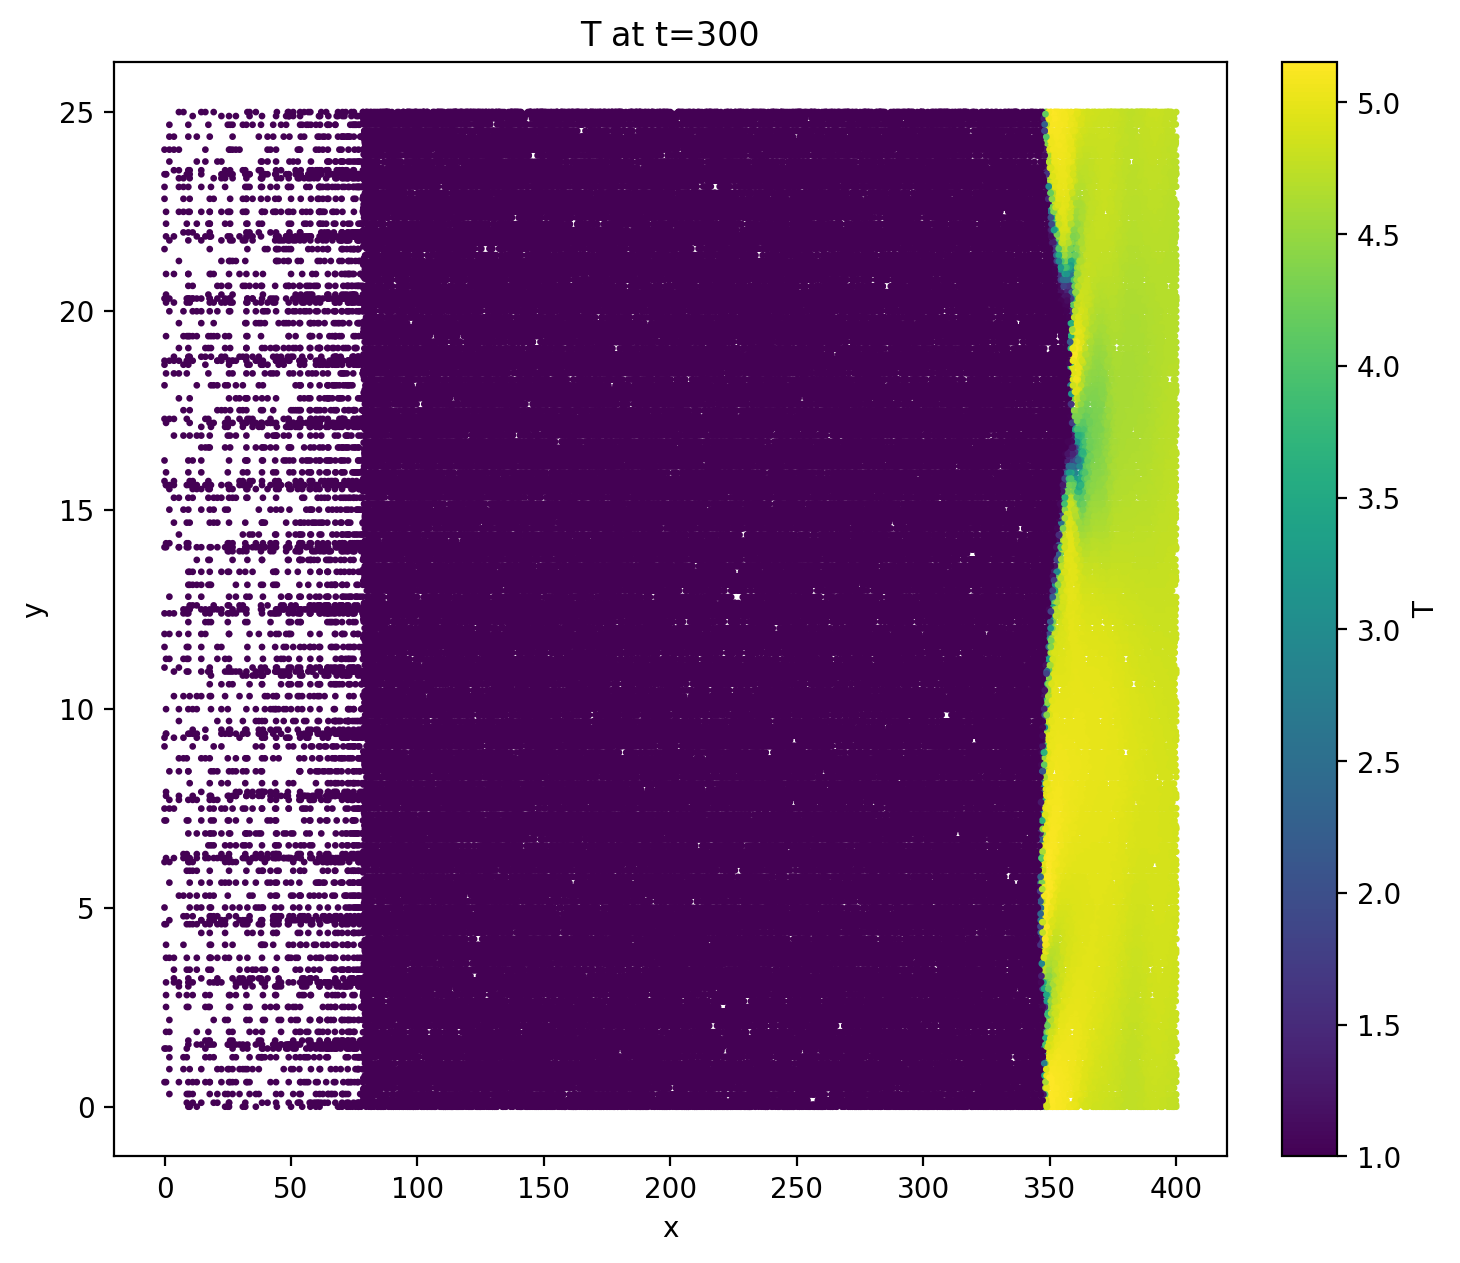

In [5]:
# Plot a variable over the full field
import matplotlib.pyplot as plt
from flamekit.io_fields import load_field_hdf5

PLOT_VAR = "T"
MAX_FIELD_POINTS = 200000

plot_ts = TIME_STEP_END if MULTI_TIME_STEP else TIME_STEP
plot_case = Case(
    base_dir=OUTPUT_BASE_DIR,
    phi=PHI,
    lat_size=LAT_SIZE,
    time_step=plot_ts,
    post=POST,
)

if rank == 0:
    field_df = load_field_hdf5(plot_case, required_cols=["x", "y", PLOT_VAR])
    if len(field_df) > MAX_FIELD_POINTS:
        field_df = field_df.sample(MAX_FIELD_POINTS, random_state=42)

    fig, ax = plt.subplots(figsize=(7.2, 6.2), dpi=200, constrained_layout=True)
    sc = ax.scatter(
        field_df["x"],
        field_df["y"],
        c=field_df[PLOT_VAR],
        s=2,
        cmap="viridis",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{PLOT_VAR} at t={plot_ts}")
    plt.colorbar(sc, ax=ax, label=PLOT_VAR)
    plt.show()
    plt.close(fig)
